In [1]:
jsonl_path = "/home/yb107/cvpr2025/DukeDiffSeg/data/3d_vlsm_v2/3d_vlsm_v2_train.jsonl"
import json
import os

# read the JSONL file
files = []

with open(jsonl_path, "r") as file:
    for line in file:
        files.append(json.loads(line)["mask"])
files = files[:1]

In [10]:
import monai
from monai.transforms import (
    LoadImage,
    EnsureChannelFirst,
    ScaleIntensity,
    ToTensor,
    CropForeground,
    Orientation,
    Spacing,
    Resize,
    SaveImage,
    AsDiscrete,
    ToTensor,
)

transform = monai.transforms.Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        Orientation(axcodes="RAS"),
        Spacing(pixdim=(1.0, 1.0, 3.0), mode=("nearest")),
        CropForeground(),
        # Resize(
        #     spatial_size=(96, 96, 96),
        #     mode="nearest",
        # ),
        # SaveImage(
        #     output_dir="/home/yb107/cvpr2025/DukeDiffSeg/notebook/tmp",
        #     separate_folder=False,
        #     output_ext=".nii.gz",
        #     output_postfix="96",
        # ),
        ToTensor(),
    ]
)

imgs = transform(files)

# output_file = "/home/yb107/cvpr2025/DukeDiffSeg/notebook/diffusion_dataprep_shapes.txt"
# with open(output_file, "w") as f:
#     for img in imgs:
#         f.write(f"{img.meta['filename_or_obj'].split('/')[-1]},{img.shape}\n")

/home/yb107/.local/share/virtualenvs/DukeDiffSeg-HooVw7aP/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.array CropForeground.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


## EigenColon Decompositions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

stats_file = "/home/yb107/cvpr2025/DukeDiffSeg/notebook/data/eigencolon_stats.npz"
stats = np.load(stats_file)
print("Available arrays:", stats.files)

Available arrays: ['explained_variance', 'components', 'scores', 'explained_variance_ratio']


In [3]:
explained = stats["explained_variance"]  # raw eigenvalues
components = stats["components"]  # shape (n_components, V)
scores = stats["scores"]  # shape (N, n_components)
evr = stats["explained_variance_ratio"]  # shape (n_components,)
cumvar = np.cumsum(evr)

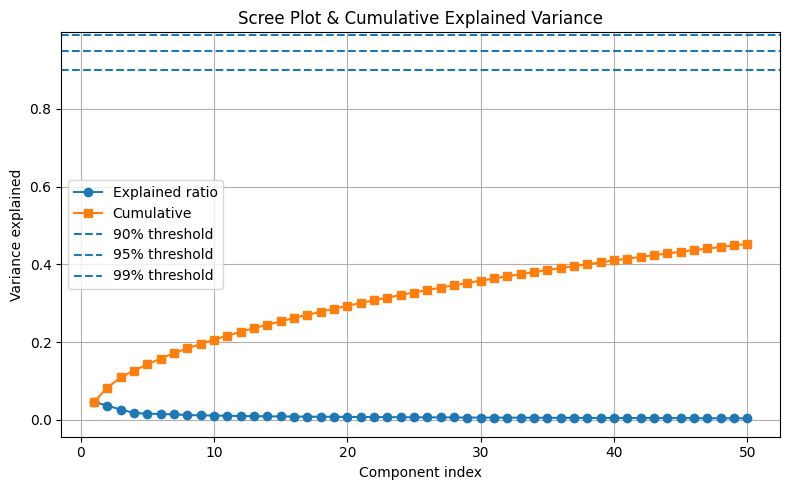

In [4]:
# 3) Scree plot and cumulative variance
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(evr) + 1), evr, "-o", label="Explained ratio")
plt.plot(np.arange(1, len(cumvar) + 1), cumvar, "-s", label="Cumulative")
# thresholds
for t, style in zip([0.90, 0.95, 0.99], ["--", "--", "--"]):
    plt.axhline(t, linestyle=style, label=f"{int(t*100)}% threshold")
plt.xlabel("Component index")
plt.ylabel("Variance explained")
plt.title("Scree Plot & Cumulative Explained Variance")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
for threshold in [0.90, 0.95, 0.99]:
    k = np.searchsorted(cumvar, threshold) + 1
    print(f" -> {int(threshold*100)}% variance achieved by {k} components")

 -> 90% variance achieved by 51 components
 -> 95% variance achieved by 51 components
 -> 99% variance achieved by 51 components


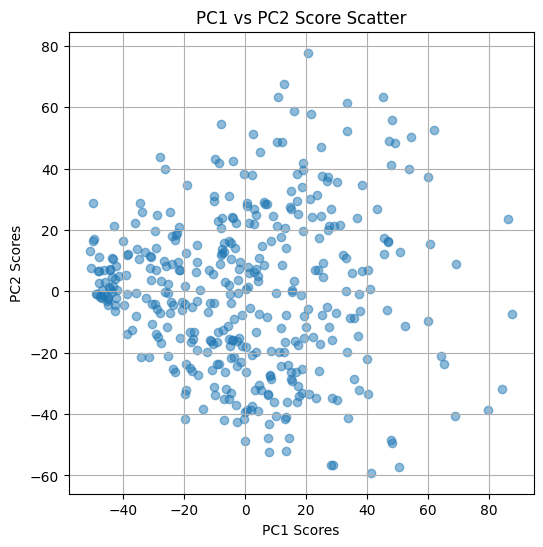

In [6]:
plt.figure(figsize=(6, 6))
plt.scatter(scores[:, 0], scores[:, 1], alpha=0.5)
plt.xlabel("PC1 Scores")
plt.ylabel("PC2 Scores")
plt.title("PC1 vs PC2 Score Scatter")
plt.grid(True)
plt.show()

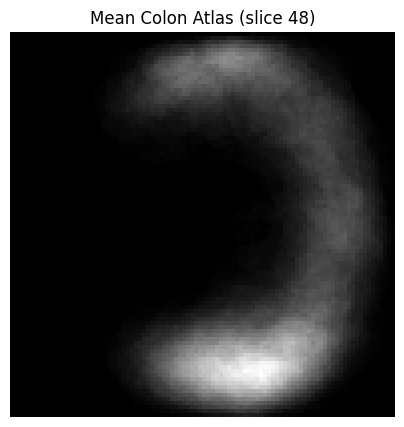

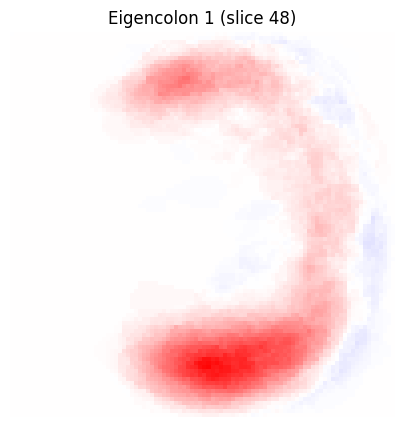

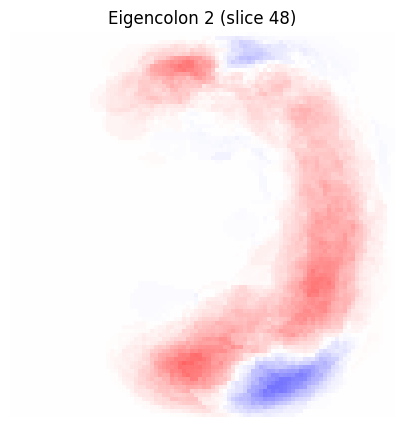

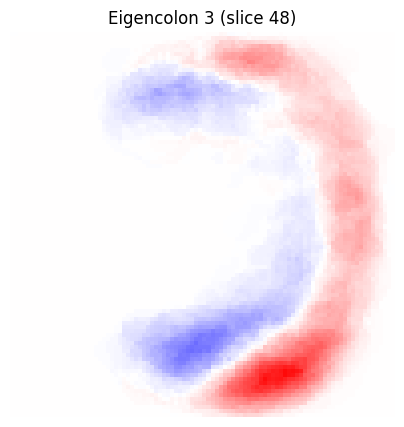

In [7]:
# 5) Visualize mean atlas and first eigencolons
# Load mean atlas
mean_path = "/home/yb107/cvpr2025/DukeDiffSeg/notebook/data/mean_colon_atlas.nii.gz"
mean_img = nib.load(mean_path)
mean_vol = mean_img.get_fdata()
# central slice
z0 = mean_vol.shape[2] // 2

# Plot mean atlas
plt.figure(figsize=(5, 5))
plt.imshow(mean_vol[:, :, z0], cmap="gray")
plt.title("Mean Colon Atlas (slice {})".format(z0))
plt.axis("off")
plt.show()

# Plot first 3 eigencolons
for i in range(min(3, components.shape[0])):
    vol = components[i].reshape(mean_vol.shape)
    plt.figure(figsize=(5, 5))
    plt.imshow(
        vol[:, :, z0], cmap="bwr", vmin=-np.max(np.abs(vol)), vmax=np.max(np.abs(vol))
    )
    plt.title(f"Eigencolon {i+1} (slice {z0})")
    plt.axis("off")
    plt.show()

In [8]:
# %%
# 6) Save all eigencolons as NIfTI volumes
# Use header/affine from the mean atlas image
affine = mean_img.affine
header = mean_img.header
num_comp = components.shape[0]
for idx in range(num_comp):
    vec = components[idx]
    vol = vec.reshape(mean_vol.shape)
    out_img = nib.Nifti1Image(vol, affine, header)
    filename = (
        f"/home/yb107/cvpr2025/DukeDiffSeg/notebook/data/eigencolon_{idx+1:03d}.nii.gz"
    )
    nib.save(out_img, filename)
    print(f"Saved {filename}")

Saved /home/yb107/cvpr2025/DukeDiffSeg/notebook/data/eigencolon_001.nii.gz
Saved /home/yb107/cvpr2025/DukeDiffSeg/notebook/data/eigencolon_002.nii.gz
Saved /home/yb107/cvpr2025/DukeDiffSeg/notebook/data/eigencolon_003.nii.gz
Saved /home/yb107/cvpr2025/DukeDiffSeg/notebook/data/eigencolon_004.nii.gz
Saved /home/yb107/cvpr2025/DukeDiffSeg/notebook/data/eigencolon_005.nii.gz
Saved /home/yb107/cvpr2025/DukeDiffSeg/notebook/data/eigencolon_006.nii.gz
Saved /home/yb107/cvpr2025/DukeDiffSeg/notebook/data/eigencolon_007.nii.gz
Saved /home/yb107/cvpr2025/DukeDiffSeg/notebook/data/eigencolon_008.nii.gz
Saved /home/yb107/cvpr2025/DukeDiffSeg/notebook/data/eigencolon_009.nii.gz
Saved /home/yb107/cvpr2025/DukeDiffSeg/notebook/data/eigencolon_010.nii.gz
Saved /home/yb107/cvpr2025/DukeDiffSeg/notebook/data/eigencolon_011.nii.gz
Saved /home/yb107/cvpr2025/DukeDiffSeg/notebook/data/eigencolon_012.nii.gz
Saved /home/yb107/cvpr2025/DukeDiffSeg/notebook/data/eigencolon_013.nii.gz
Saved /home/yb107/cvpr202

In [2]:
import numpy as np

npz_file = "../outputs/debug/pred_xstart.npz"
data = np.load(npz_file)
print("Available arrays in npz file:", data.files)

Available arrays in npz file: ['pred_xstart', 'structure_mask']


In [4]:
pred_xstart = data["pred_xstart"]
structure = data["structure_mask"]
print("Shape of pred_xstart:", pred_xstart[:, 1, ...].shape)
print("Shape of structure mask:", structure.shape)

Shape of pred_xstart: (1, 96, 96, 96)
Shape of structure mask: (1, 96, 96, 96)
